installements

In [1]:
!pip install pycaret
!pip install pyspark
!pip install openpyxl


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
from google.colab import files
import pandas as pd
from pyspark.sql.functions import col, trim, upper, regexp_replace, initcap
import numpy as np
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split

In [3]:
# Create a Spark session
spark = SparkSession.builder.appName("ExcelDataProcessing").getOrCreate()


In [ ]:
uploaded = files.upload()


Saving olympic_medals.xlsx to olympic_medals (1).xlsx


In [ ]:


# Initialiser Spark
spark = SparkSession.builder.appName("ExcelDataProcessing").getOrCreate()

# Lire le fichier Excel téléchargé
file_name = list(uploaded.keys())[0]
pd_df = pd.read_excel(file_name, engine='openpyxl')

# Convertir le DataFrame Pandas en DataFrame Spark
spark_df = spark.createDataFrame(pd_df)

# Afficher le DataFrame
spark_df.show()


+----------+----------------+------------+--------------------+------------+----------+----------------+-----------------+--------------------+--------------------+--------------------+------------+---------------------+
|Unnamed: 0|discipline_title|   slug_game|         event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|        country_name|country_code|country_3_letter_code|
+----------+----------------+------------+--------------------+------------+----------+----------------+-----------------+--------------------+--------------------+--------------------+------------+---------------------+
|         0|         Curling|beijing-2022|       Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania CONSTANTINI|               Italy|          IT|                  ITA|
|         1|         Curling|beijing-2022|       Mixed Doubles|       Mixed|      GOLD|        GameTeam|            

In [ ]:
spark = SparkSession.builder.appName("ExcelDataProcessing").getOrCreate()


columns_to_drop = ['Unnamed: 0']
spark_df = spark_df.drop(*columns_to_drop)


spark_df = spark_df.na.drop()


spark_df = spark_df.dropDuplicates()


def standardize_column_names(df):
    for column in df.columns:
        new_column = column.strip().lower().replace(' ', '_')
        df = df.withColumnRenamed(column, new_column)
    return df

spark_df = standardize_column_names(spark_df)


spark_df = spark_df.withColumn("athlete_full_name", initcap(col("athlete_full_name")))


spark_df.show()



+--------------------+----------------+--------------------+------------+----------+----------------+--------------------+--------------------+--------------------+--------------------+------------+---------------------+
|    discipline_title|       slug_game|         event_title|event_gender|medal_type|participant_type|   participant_title|         athlete_url|   athlete_full_name|        country_name|country_code|country_3_letter_code|
+--------------------+----------------+--------------------+------------+----------+----------------+--------------------+--------------------+--------------------+--------------------+------------+---------------------+
|        Canoe Sprint|      tokyo-2020|Women's Kayak Dou...|       Women|      GOLD|        GameTeam|         New Zealand|https://olympics....|     Lisa Carrington|         New Zealand|          NZ|                  NZL|
|              Boxing|      tokyo-2020|Men's Welter (63-...|         Men|      GOLD|         Athlete|               

In [ ]:
pandas_df = spark_df.toPandas()

discipline_title             0
slug_game                    0
event_title                  0
event_gender                 0
medal_type                   0
participant_type             0
participant_title        15113
athlete_url               4670
athlete_full_name         3624
country_name                 0
country_code              1502
country_3_letter_code        0
dtype: int64


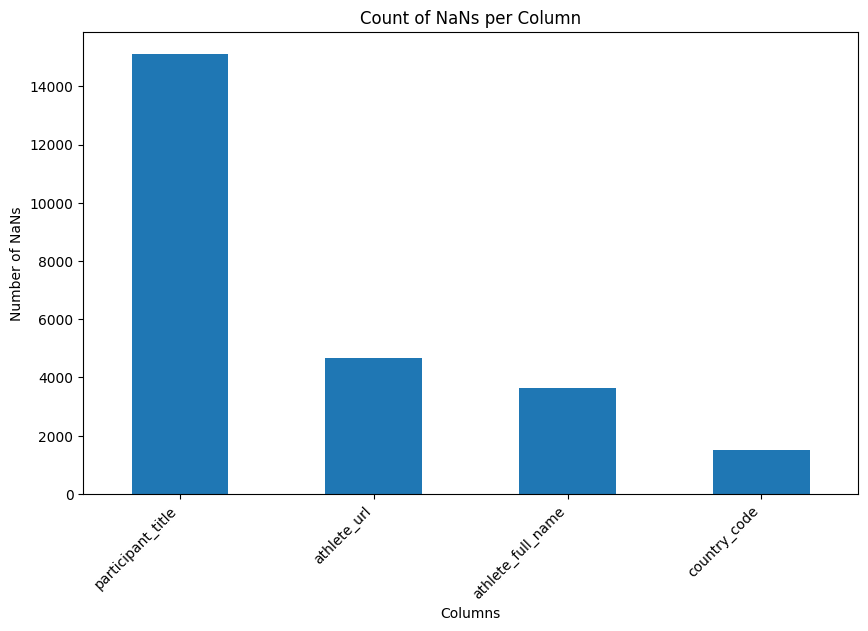

In [ ]:
pandas_df.replace(["N/A", "NA", "null", "", "NaN", "Nan", "<NA>"], pd.NA, inplace=True)

# Check for NaNs in the DataFrame
nan_counts = pandas_df.isna().sum()

# Print the NaN counts to verify
print(nan_counts)

# Filter columns with NaNs for plotting
nan_counts = nan_counts[nan_counts > 0]

# Plot the counts using Matplotlib if there are any NaNs
if not nan_counts.empty:
    plt.figure(figsize=(10, 6))
    nan_counts.plot(kind='bar')
    plt.title('Count of NaNs per Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of NaNs')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("No missing values found in the DataFrame.")

In [ ]:
def extract_name_from_url(url):
    if pd.isna(url):
        return np.nan
    return url.split('/')[-1].replace('-', ' ').title()

# Function to create URL from athlete's name
def create_url_from_name(name):
    if pd.isna(name):
        return np.nan
    return f"https://olympics.com/en/athletes/{name.replace(' ', '-').lower()}"

# Fill missing athlete_full_name using athlete_url
pandas_df['athlete_full_name'] = pandas_df.apply(
    lambda row: extract_name_from_url(row['athlete_url']) if pd.isna(row['athlete_full_name']) else row['athlete_full_name'],
    axis=1
)

# Fill missing athlete_url using athlete_full_name
pandas_df['athlete_url'] = pandas_df.apply(
    lambda row: create_url_from_name(row['athlete_full_name']) if pd.isna(row['athlete_url']) else row['athlete_url'],
    axis=1
)

# Display the DataFrame to verify the changes
pandas_df

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,participant_title,athlete_url,athlete_full_name,country_name,country_code,country_3_letter_code
0,Canoe Sprint,tokyo-2020,Women's Kayak Double 500m,Women,GOLD,GameTeam,New Zealand,https://olympics.com/en/athletes/lisa-carrington,Lisa Carrington,New Zealand,NZ,NZL
1,Boxing,tokyo-2020,Men's Welter (63-69kg),Men,GOLD,Athlete,<NA>,https://olympics.com/en/athletes/roniel-iglesias,Roniel Iglesias,Cuba,CU,CUB
2,Badminton,tokyo-2020,Men's Doubles,Men,BRONZE,GameTeam,CHIA Aaron/SOH Wooi Yik,https://olympics.com/en/athletes/aaron-chia,Aaron Chia,Malaysia,MY,MAS
3,Judo,tokyo-2020,Men +100 kg,Men,BRONZE,Athlete,<NA>,https://olympics.com/en/athletes/tamerlan-bashaev,Tamerlan Bashaev,ROC,ROC,ROC
4,Athletics,tokyo-2020,Men's 4 x 100m Relay,Men,SILVER,GameTeam,Great Britain,NaN,NaN,Great Britain,GB,GBR
...,...,...,...,...,...,...,...,...,...,...,...,...
21692,Weightlifting,mexico-city-1968,56 - 60kg (featherweight) men,Men,BRONZE,Athlete,<NA>,https://olympics.com/en/athletes/yoshiyuki-miyake,Yoshiyuki Miyake,Japan,JP,JPN
21693,Athletics,montreal-1976,marathon men,Men,BRONZE,Athlete,<NA>,https://olympics.com/en/athletes/karel-lismont,Karel Lismont,Belgium,BE,BEL
21694,Swimming,melbourne-1956,100m backstroke women,Women,BRONZE,Athlete,<NA>,https://olympics.com/en/athletes/margaret-edwards,Margaret Edwards,Great Britain,GB,GBR
21695,Cycling Track,los-angeles-1984,1km time trial men,Men,GOLD,Athlete,<NA>,https://olympics.com/en/athletes/fredy-schmidtke,Fredy Schmidtke,Federal Republic of Germany,DE,FRG


discipline_title             0
slug_game                    0
event_title                  0
event_gender                 0
medal_type                   0
participant_type             0
participant_title        15113
athlete_url               3624
athlete_full_name         3624
country_name                 0
country_code              1502
country_3_letter_code        0
dtype: int64


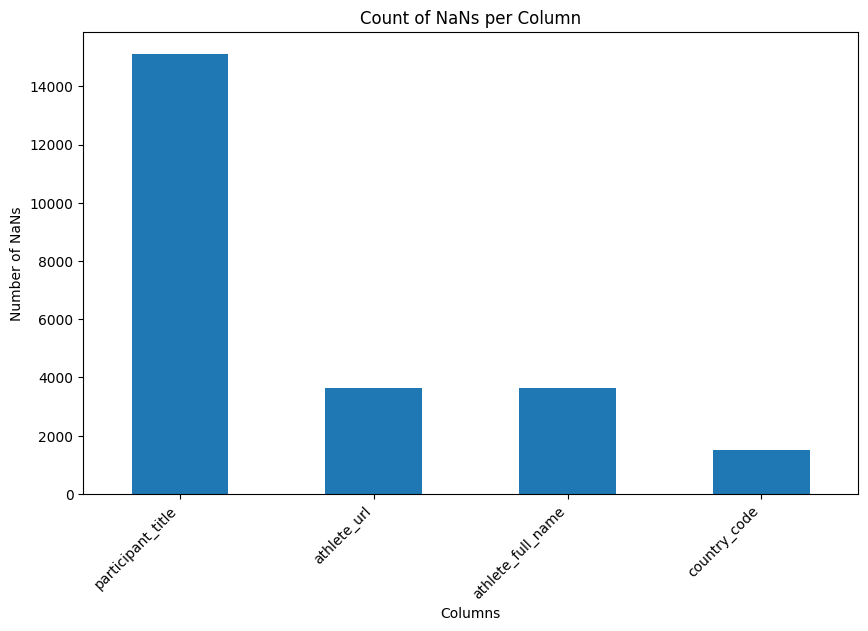

In [ ]:
nan_counts = pandas_df.isna().sum()

# Print the NaN counts to verify
print(nan_counts)

# Filter columns with NaNs for plotting
nan_counts = nan_counts[nan_counts > 0]

# Plot the counts using Matplotlib if there are any NaNs
if not nan_counts.empty:
    plt.figure(figsize=(10, 6))
    nan_counts.plot(kind='bar')
    plt.title('Count of NaNs per Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of NaNs')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print("No missing values found in the DataFrame.")

In [ ]:
pandas_df = pandas_df.drop(columns=['country_code'])


In [ ]:
pandas_df = pandas_df.drop(columns=['participant_title'])


In [ ]:
pandas_df

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,athlete_url,athlete_full_name,country_name,country_3_letter_code
0,Canoe Sprint,tokyo-2020,Women's Kayak Double 500m,Women,GOLD,GameTeam,https://olympics.com/en/athletes/lisa-carrington,Lisa Carrington,New Zealand,NZL
1,Boxing,tokyo-2020,Men's Welter (63-69kg),Men,GOLD,Athlete,https://olympics.com/en/athletes/roniel-iglesias,Roniel Iglesias,Cuba,CUB
2,Badminton,tokyo-2020,Men's Doubles,Men,BRONZE,GameTeam,https://olympics.com/en/athletes/aaron-chia,Aaron Chia,Malaysia,MAS
3,Judo,tokyo-2020,Men +100 kg,Men,BRONZE,Athlete,https://olympics.com/en/athletes/tamerlan-bashaev,Tamerlan Bashaev,ROC,ROC
4,Athletics,tokyo-2020,Men's 4 x 100m Relay,Men,SILVER,GameTeam,NaN,NaN,Great Britain,GBR
...,...,...,...,...,...,...,...,...,...,...
21692,Weightlifting,mexico-city-1968,56 - 60kg (featherweight) men,Men,BRONZE,Athlete,https://olympics.com/en/athletes/yoshiyuki-miyake,Yoshiyuki Miyake,Japan,JPN
21693,Athletics,montreal-1976,marathon men,Men,BRONZE,Athlete,https://olympics.com/en/athletes/karel-lismont,Karel Lismont,Belgium,BEL
21694,Swimming,melbourne-1956,100m backstroke women,Women,BRONZE,Athlete,https://olympics.com/en/athletes/margaret-edwards,Margaret Edwards,Great Britain,GBR
21695,Cycling Track,los-angeles-1984,1km time trial men,Men,GOLD,Athlete,https://olympics.com/en/athletes/fredy-schmidtke,Fredy Schmidtke,Federal Republic of Germany,FRG


In [ ]:
pandas_df.to_csv("cleaned_olympic_medals_data.csv", index=False)

# Download the CSV file

files.download("cleaned_olympic_medals_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
uploaded = files.upload()

Saving cleaned_olympic_medals_data.csv to cleaned_olympic_medals_data.csv


In [24]:
df = pd.read_csv("cleaned_olympic_medals_data.csv")


In [25]:
pandas_df = df

In [6]:
df.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,athlete_url,athlete_full_name,country_name,country_3_letter_code
0,Canoe Sprint,tokyo-2020,Women's Kayak Double 500m,Women,GOLD,GameTeam,https://olympics.com/en/athletes/lisa-carrington,Lisa Carrington,New Zealand,NZL
1,Boxing,tokyo-2020,Men's Welter (63-69kg),Men,GOLD,Athlete,https://olympics.com/en/athletes/roniel-iglesias,Roniel Iglesias,Cuba,CUB
2,Badminton,tokyo-2020,Men's Doubles,Men,BRONZE,GameTeam,https://olympics.com/en/athletes/aaron-chia,Aaron Chia,Malaysia,MAS
3,Judo,tokyo-2020,Men +100 kg,Men,BRONZE,Athlete,https://olympics.com/en/athletes/tamerlan-bashaev,Tamerlan Bashaev,ROC,ROC
4,Athletics,tokyo-2020,Men's 4 x 100m Relay,Men,SILVER,GameTeam,NaN,NaN,Great Britain,GBR


In [7]:
# Check for missing values in each column
na_counts = df.isna().sum()
print("Count of missing values in each column:")
print(na_counts)

# Display the first few rows of the DataFrame to understand its structure
print("First few rows of the DataFrame:")
df.head()


Count of missing values in each column:
discipline_title            0
slug_game                   0
event_title                 0
event_gender                0
medal_type                  0
participant_type            0
athlete_url              3624
athlete_full_name        3624
country_name                0
country_3_letter_code       0
dtype: int64
First few rows of the DataFrame:


,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,athlete_url,athlete_full_name,country_name,country_3_letter_code
0,Canoe Sprint,tokyo-2020,Women's Kayak Double 500m,Women,GOLD,GameTeam,https://olympics.com/en/athletes/lisa-carrington,Lisa Carrington,New Zealand,NZL
1,Boxing,tokyo-2020,Men's Welter (63-69kg),Men,GOLD,Athlete,https://olympics.com/en/athletes/roniel-iglesias,Roniel Iglesias,Cuba,CUB
2,Badminton,tokyo-2020,Men's Doubles,Men,BRONZE,GameTeam,https://olympics.com/en/athletes/aaron-chia,Aaron Chia,Malaysia,MAS
3,Judo,tokyo-2020,Men +100 kg,Men,BRONZE,Athlete,https://olympics.com/en/athletes/tamerlan-bashaev,Tamerlan Bashaev,ROC,ROC
4,Athletics,tokyo-2020,Men's 4 x 100m Relay,Men,SILVER,GameTeam,NaN,NaN,Great Britain,GBR


In [8]:
# Summary statistics of the dataset
summary_stats = df.describe(include='all')
print("Summary statistics of the dataset:")
summary_stats


Summary statistics of the dataset:


,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,athlete_url,athlete_full_name,country_name,country_3_letter_code
count,21697,21697,21697,21697,21697,21697,18073,18073,21697,21697
unique,86,53,1436,4,3,2,12908,12889,154,154
top,Athletics,tokyo-2020,Individual men,Men,BRONZE,Athlete,https://olympics.com/en/athletes/michael-phelp...,Michael Phelps,United States of America,USA
freq,3080,1188,215,13932,7529,15113,16,16,3094,3094


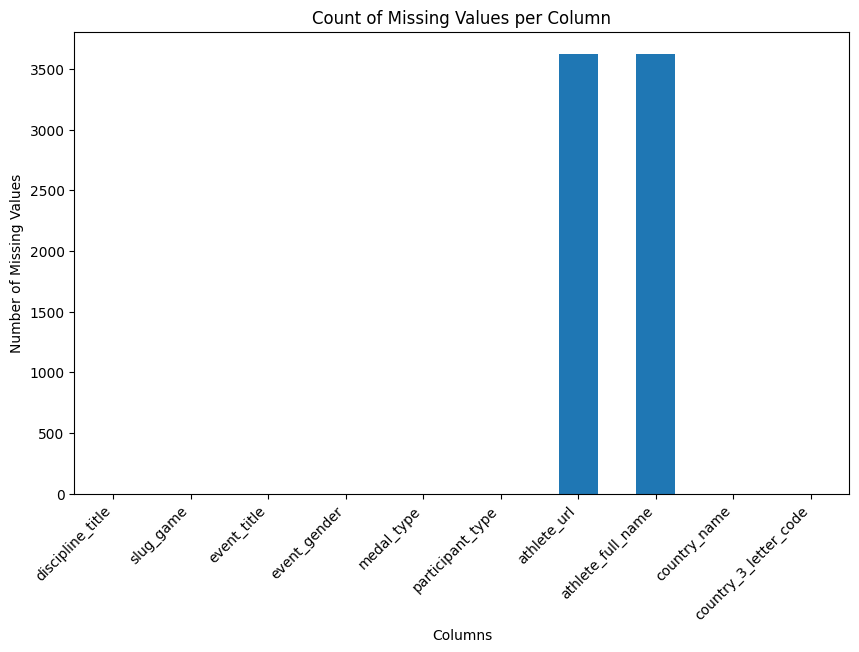

In [9]:
import matplotlib.pyplot as plt

# Plot the count of missing values per column
plt.figure(figsize=(10, 6))
na_counts.plot(kind='bar')
plt.title('Count of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.show()


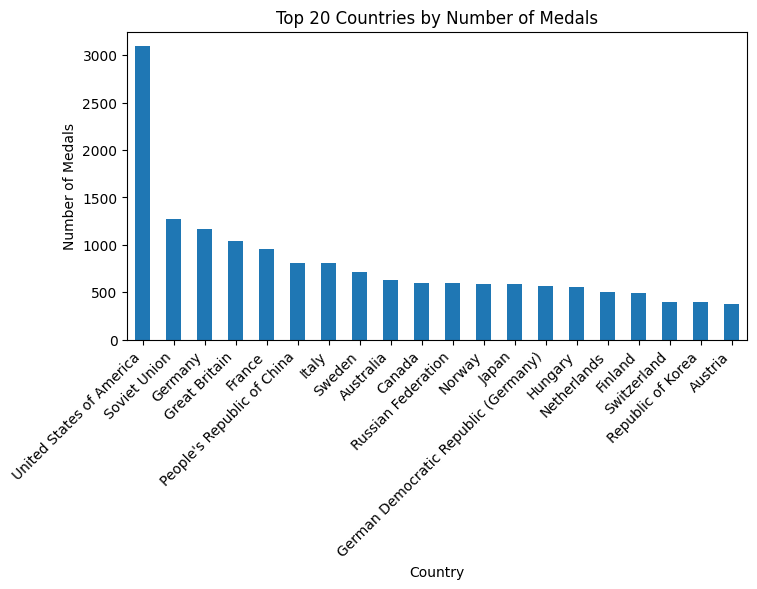

In [10]:
# Distribution of medals by country (Top 20)
medals_by_country = df['country_name'].value_counts().head(20)
plt.figure(figsize=(8, 4))
medals_by_country.plot(kind='bar')
plt.title('Top 20 Countries by Number of Medals')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.xticks(rotation=45, ha='right')
plt.show()



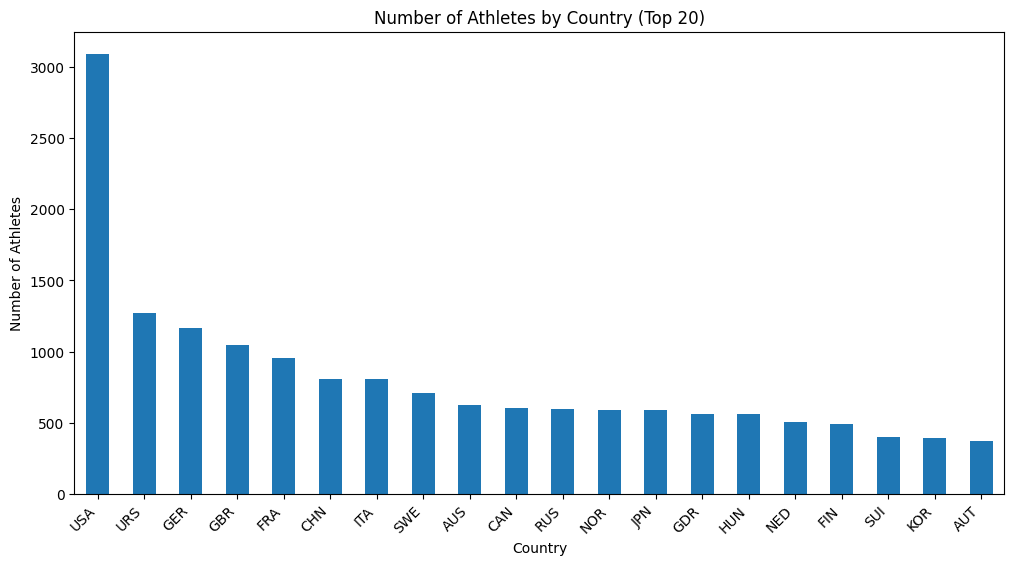

In [11]:
athletes_by_country = df['country_3_letter_code'].value_counts().head(20)

# Plot the number of athletes by country
plt.figure(figsize=(12, 6))
athletes_by_country.plot(kind='bar')
plt.title('Number of Athletes by Country (Top 20)')
plt.xlabel('Country')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=45, ha='right')
plt.show()

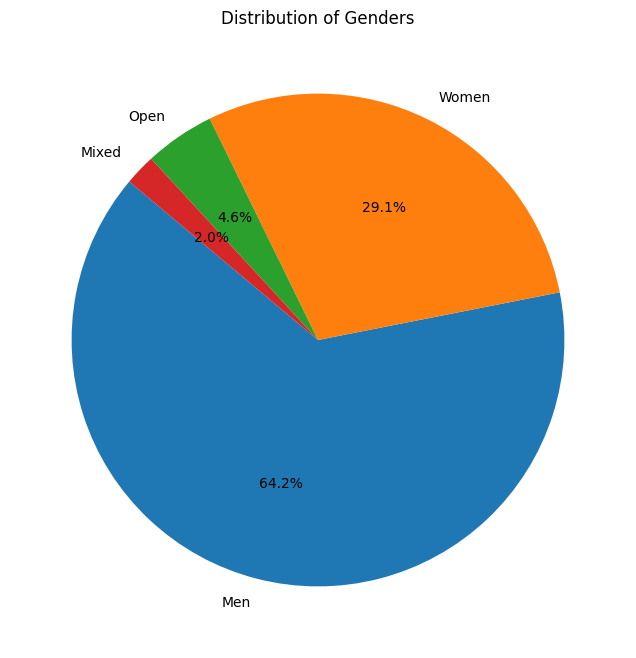

In [12]:
plt.figure(figsize=(8, 8))
gender_counts = df['event_gender'].value_counts()
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Genders')
plt.ylabel('')  # Hide the y-label
plt.show()

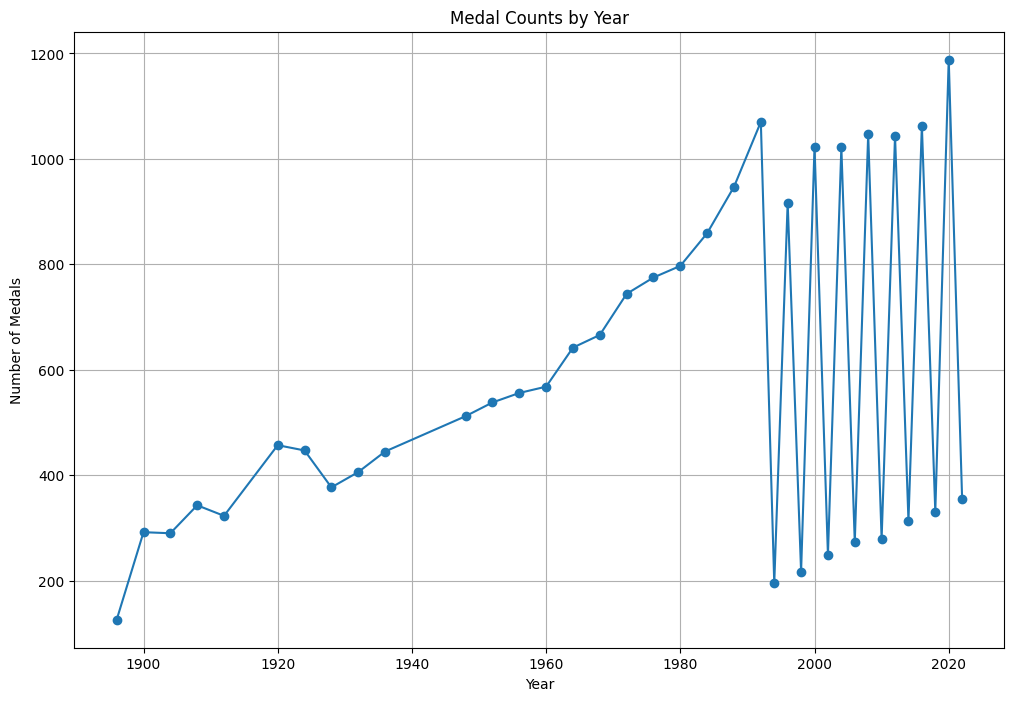

In [13]:
df['year'] = df['slug_game'].apply(lambda x: int(x.split('-')[-1]))

# Group by year and count the number of medals
medals_by_year = df.groupby('year').size()

# Plot the medal counts by year
plt.figure(figsize=(12, 8))
medals_by_year.plot(kind='line', marker='o')
plt.title('Medal Counts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.grid(True)
plt.show()

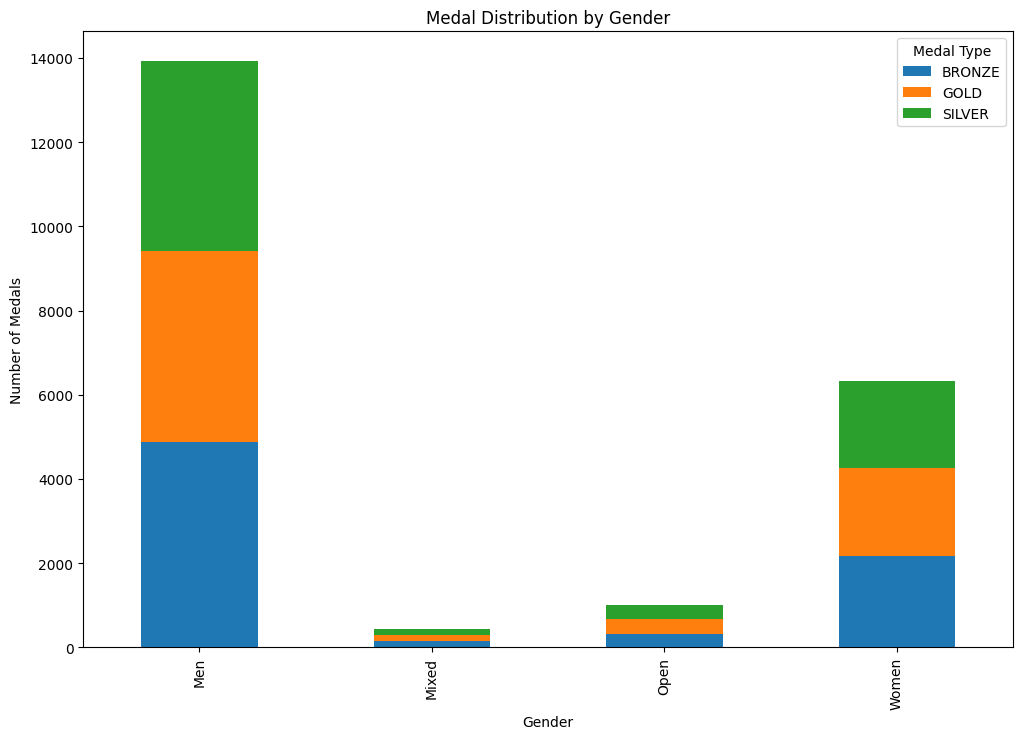

In [14]:
medals_by_gender = df.groupby(['event_gender', 'medal_type']).size().unstack(fill_value=0)

# Plot the stacked bar chart
medals_by_gender.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Medal Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Medals')
plt.legend(title='Medal Type')
plt.show()

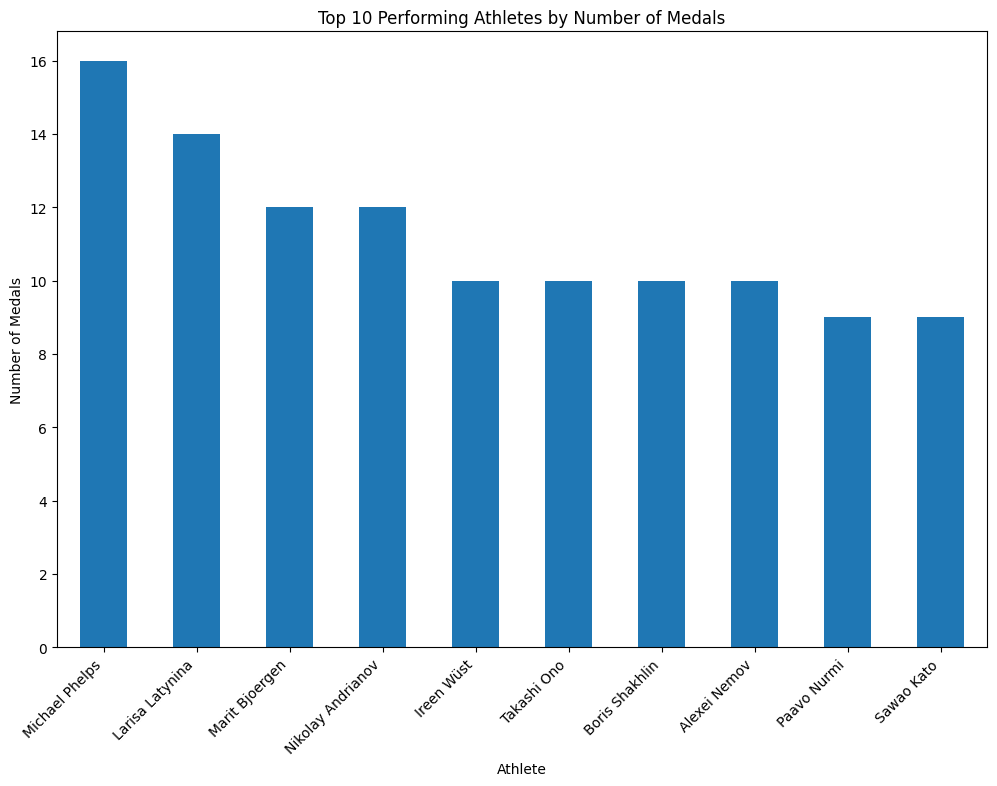

In [15]:
top_athletes = df['athlete_full_name'].value_counts().head(10)  # Top 10 athletes

# Plot the bar chart
plt.figure(figsize=(12, 8))
top_athletes.plot(kind='bar')
plt.title('Top 10 Performing Athletes by Number of Medals')
plt.xlabel('Athlete')
plt.ylabel('Number of Medals')
plt.xticks(rotation=45, ha='right')
plt.show()

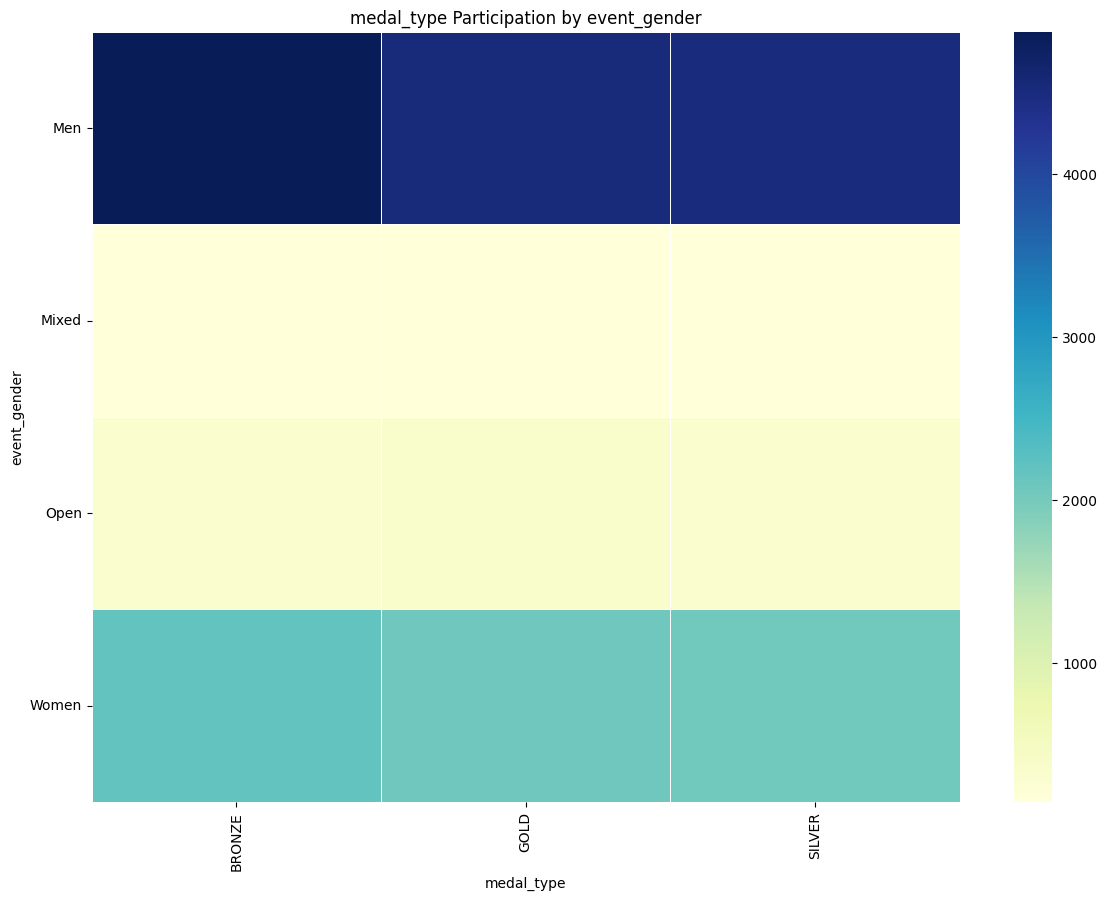

In [16]:
participation_pivot = df.pivot_table(index='event_gender', columns='medal_type', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(participation_pivot, cmap="YlGnBu", linewidths=.5)
plt.title('medal_type Participation by event_gender')
plt.xlabel('medal_type')
plt.ylabel('event_gender')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

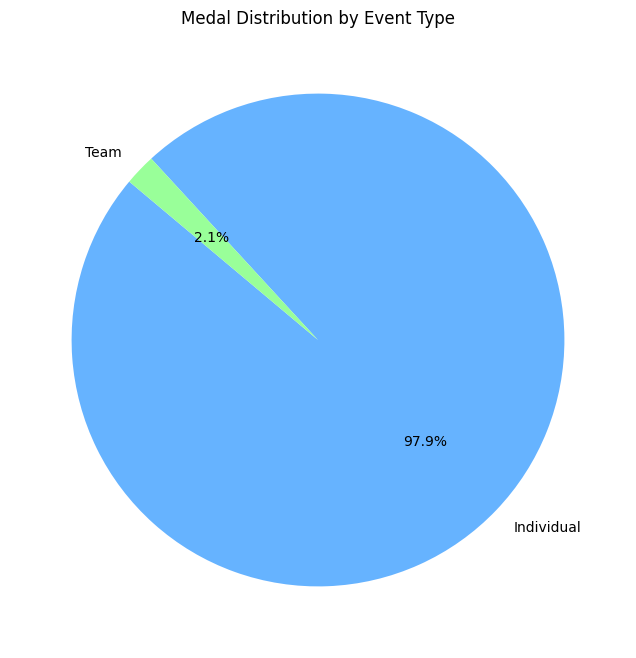

In [17]:
df['event_type'] = df['event_title'].apply(lambda x: 'Team' if 'Team' in x else 'Individual')

# Count the number of medals for each event type
medals_by_event_type = df['event_type'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
medals_by_event_type.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99'])
plt.title('Medal Distribution by Event Type')
plt.ylabel('')  # Hide the y-label
plt.show()

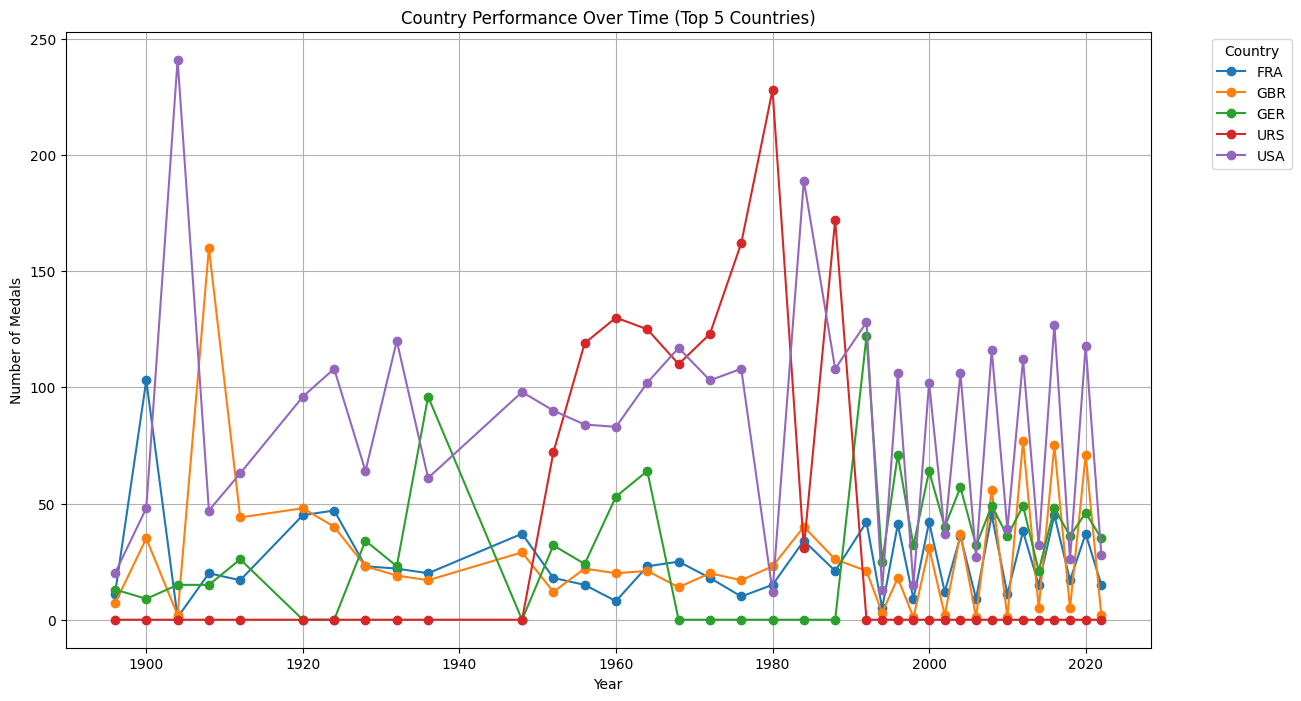

In [18]:
df['year'] = df['slug_game'].apply(lambda x: int(x.split('-')[-1]))

# Get the top 10 countries by the number of medals
top_countries = df['country_3_letter_code'].value_counts().head(5).index

# Filter the DataFrame for the top 10 countries
filtered_df = df[df['country_3_letter_code'].isin(top_countries)]

# Group by year and country and count the number of medals
medals_by_year_country = filtered_df.groupby(['year', 'country_3_letter_code']).size().unstack(fill_value=0)

# Plot the multi-line chart
plt.figure(figsize=(14, 8))
for country in medals_by_year_country.columns:
    plt.plot(medals_by_year_country.index, medals_by_year_country[country], marker='o', label=country)

plt.title('Country Performance Over Time (Top 5 Countries)')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

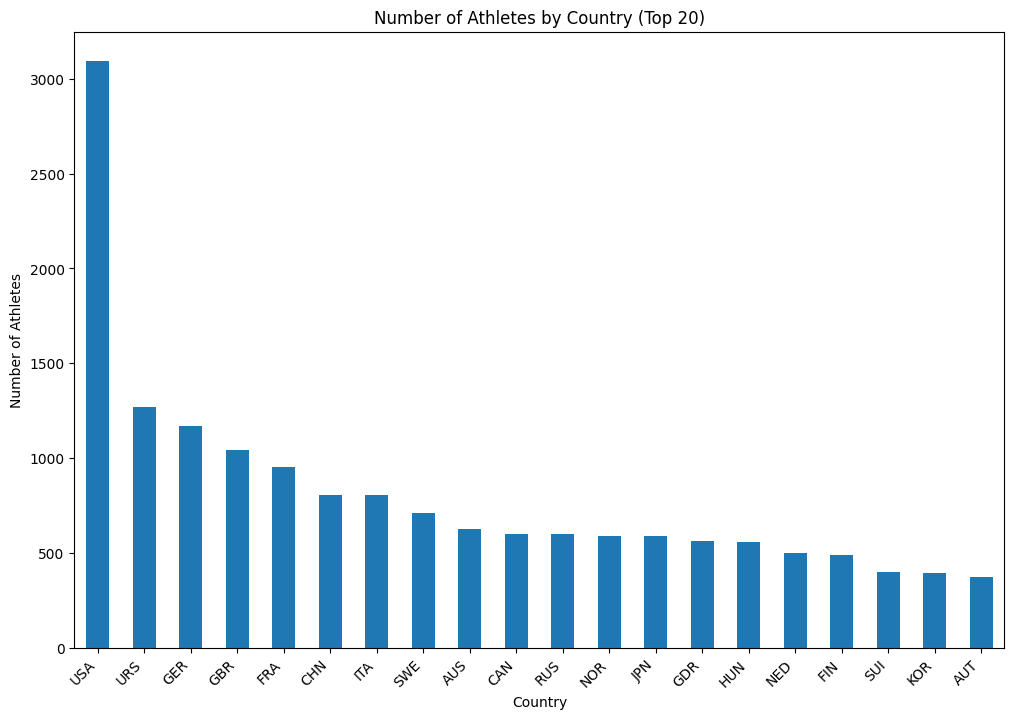

In [19]:
# Count the number of athletes by country using the 3-letter country code
athletes_by_country = df['country_3_letter_code'].value_counts().head(20)

# Plot the number of athletes by country
plt.figure(figsize=(12, 8))
athletes_by_country.plot(kind='bar')
plt.title('Number of Athletes by Country (Top 20)')
plt.xlabel('Country')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=45, ha='right')
plt.show()

In [20]:
# Count the number of athletes per event
top_events = df['event_title'].value_counts().head(10).index  # Top 10 events

# Filter the DataFrame to include only the top events
filtered_df = df[df['event_title'].isin(top_events)]

# Create a new column with a constant value of 1 to represent the count of medals
filtered_df['medal_count'] = 1

# Create a treemap to show medal distribution by discipline for the top events
fig = px.treemap(filtered_df,
                 path=['discipline_title', 'event_title', 'medal_type'],
                 values='medal_count',  # Use the new column for counting
                 title='Medal Distribution by Discipline (Top Events)',
                 color='medal_type',
                 color_discrete_map={'GOLD':'gold', 'SILVER':'silver', 'BRONZE':'#cd7f32'})

fig.show()

<ipython-input-20-72ba4595acd9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['medal_count'] = 1


**Preprocessing**

In [26]:
df = pandas_df

In [29]:
data.head()

,discipline_title,slug_game,event_title,event_gender,medal_type,participant_type,athlete_url,athlete_full_name,country_name,country_3_letter_code
0,Canoe Sprint,tokyo-2020,Women's Kayak Double 500m,Women,GOLD,GameTeam,https://olympics.com/en/athletes/lisa-carrington,Lisa Carrington,New Zealand,NZL
1,Boxing,tokyo-2020,Men's Welter (63-69kg),Men,GOLD,Athlete,https://olympics.com/en/athletes/roniel-iglesias,Roniel Iglesias,Cuba,CUB
2,Badminton,tokyo-2020,Men's Doubles,Men,BRONZE,GameTeam,https://olympics.com/en/athletes/aaron-chia,Aaron Chia,Malaysia,MAS
3,Judo,tokyo-2020,Men +100 kg,Men,BRONZE,Athlete,https://olympics.com/en/athletes/tamerlan-bashaev,Tamerlan Bashaev,ROC,ROC
4,Athletics,tokyo-2020,Men's 4 x 100m Relay,Men,SILVER,GameTeam,Unknown,Unknown,Great Britain,GBR


In [30]:
data = pd.read_csv("cleaned_olympic_medals_data.csv")
df = data
relevant_columns = ['discipline_title', 'event_gender', 'medal_type', 'participant_type', 'country_3_letter_code']
df = df[relevant_columns]

# Fill missing values
df.fillna('Unknown', inplace=True)

# Drop rows where 'country_3_letter_code' is missing
df.dropna(subset=['country_3_letter_code'], inplace=True)

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['discipline_title', 'event_gender', 'medal_type', 'participant_type'])

# Aggregate data by country
feature_columns = [col for col in df.columns if col != 'country_3_letter_code']
aggregation_dict = {col: 'sum' for col in feature_columns}

aggregated_df = df.groupby('country_3_letter_code').agg(aggregation_dict).reset_index()

# The target variable: count the number of medals per country
aggregated_df['num_medals'] = df.groupby('country_3_letter_code').size().values

# Features and target variable
X = aggregated_df.drop(columns=['country_3_letter_code', 'num_medals'])
y = aggregated_df['num_medals']

<ipython-input-30-10b8b218b4bf>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-10b8b218b4bf>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Train a RandomForestRegressor to identify feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for the feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Select the top N features (e.g., top 10 features)
top_features = feature_importance_df['feature'].head(10).values
X_top_features = X[top_features]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

In [34]:
import pandas as pd
from pycaret.regression import *

# Assuming X_top_features and y have been defined as per the previous steps
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)

# Combine the training features and target into a single DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Initialize the PyCaret regression setup
regression_setup = setup(data=train_data, target='num_medals', session_id=42)

# Compare different models and select the best one
best_model = compare_models()

# Evaluate the selected model on the test data
# Prepare the test data
test_data = pd.concat([X_test, y_test], axis=1)

# Predict on the test data using the best model
predictions = predict_model(best_model, data=test_data)

# Display the performance metrics
predictions.head()


,Description,Value
0,Session id,42
1,Target,num_medals
2,Target type,Regression
3,Original data shape,"(123, 11)"
4,Transformed data shape,"(123, 11)"
5,Transformed train set shape,"(86, 11)"
6,Transformed test set shape,"(37, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0430
lasso,Lasso Regression,0.3477,0.4731,0.5748,1.0000,0.0109,0.0104,0.0310
ridge,Ridge Regression,0.0027,0.0000,0.0049,1.0000,0.0001,0.0001,0.0420
lar,Least Angle Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0390
llar,Lasso Least Angle Regression,0.0112,0.0006,0.0171,1.0000,0.0005,0.0006,0.0460
br,Bayesian Ridge,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0440
huber,Huber Regressor,0.1684,0.1833,0.2785,1.0000,0.0031,0.0027,0.0450
par,Passive Aggressive Regressor,0.6825,2.4569,1.0661,0.9999,0.0130,0.0136,0.0280
en,Elastic Net,0.4721,0.8950,0.7899,0.9999,0.0135,0.0126,0.0460
et,Extra Trees Regressor,10.6718,1395.9978,19.1534,0.9912,0.0775,0.0720,0.1320


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000


,participant_type_Athlete,medal_type_SILVER,medal_type_BRONZE,medal_type_GOLD,event_gender_Men,participant_type_GameTeam,event_gender_Women,discipline_title_Boxing,discipline_title_Diving,discipline_title_Golf,num_medals,prediction_label
15,3,1,3,0,3,1,1,0,0,0,4,4.0
94,5,5,0,0,4,0,1,0,0,0,5,5.0
152,2,1,1,0,2,0,0,1,0,0,2,2.0
105,14,5,8,1,11,0,3,8,0,0,14,14.0
109,10,2,6,2,8,0,2,6,0,0,10,10.0


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 1.8154143883958028e-26
R^2 Score: 1.0


In [42]:
# Add the country codes to the test set DataFrame
X_test['country_3_letter_code'] = aggregated_df.loc[X_test.index, 'country_3_letter_code']

# Create a DataFrame with country codes and predicted medals
results_df = pd.DataFrame({'country_3_letter_code': X_test['country_3_letter_code'], 'predicted_medals': y_pred})

# Optional: Merge with actual medal counts if needed
results_df = results_df.merge(aggregated_df[['country_3_letter_code', 'num_medals']], on='country_3_letter_code', how='left')

print(results_df.head())


  country_3_letter_code  predicted_medals  num_medals
0                   BOH               4.0           4
1                   NAM               5.0           5
2                   ZAM               2.0           2
3                   PHI              14.0          14
4                   PUR              10.0          10


In [43]:
results_df

,country_3_letter_code,predicted_medals,num_medals
0,BOH,4.0,4
1,NAM,5.0,5
2,ZAM,2.0,2
3,PHI,14.0,14
4,PUR,10.0,10
5,ISL,4.0,4
6,BRN,4.0,4
7,FRG,266.0,266
8,EGY,36.0,36
9,GUY,1.0,1
